# Direct inverse design: Tandem network

## Import modules

In [1]:
import pickle
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import helper

# Dynamic GPU memory allocation: For local prototyping, don't block GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

2023-06-21 15:52:36.520171: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 15:52:37.073288: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-21 15:52:38.078523: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-21 15:52:38.096933: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

## load the training data

In [2]:
data_path = 'datasets/dataset1_random.h5'

# load data and scalers
x_train, x_test, y_train, y_test = helper.load_reflection_spectra_data(data_path)
scaler_mat, scaler_thick = pickle.load(
    open('{}_scalers.pkl'.format(os.path.splitext(data_path)[0]), 'rb'))

## load pre-trained forward model and freeze weights

The forward model is pre-trained, we do not want it to be modified (further trained) in the inverse net training. If the forward model was subject to further training, the inputs would loose their meaning as design parameters.
We therefore need to set the forward model as not trainable. 

*Note*: If a full model is set to `trainable = False`, the model needs to be compiled, for it to have an effect. Setting the model to `trainable = False` after compilation, this does not have any effect. To avoid recompilation, every single layer can be set to `trainable=False` in a loop through the model layers, which works also on compiled models without re-compilation.

2023-06-21 15:52:39.042637: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-21 15:52:39.042835: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-21 15:52:39.042951: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

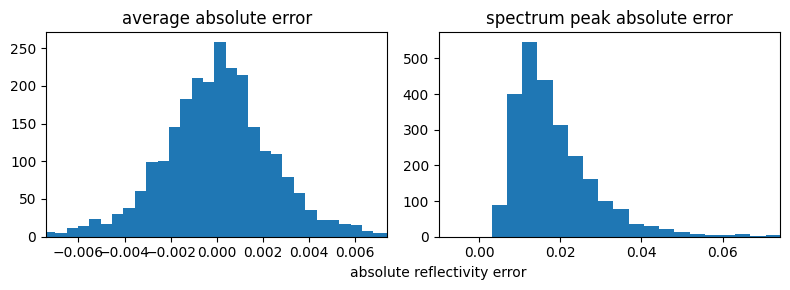

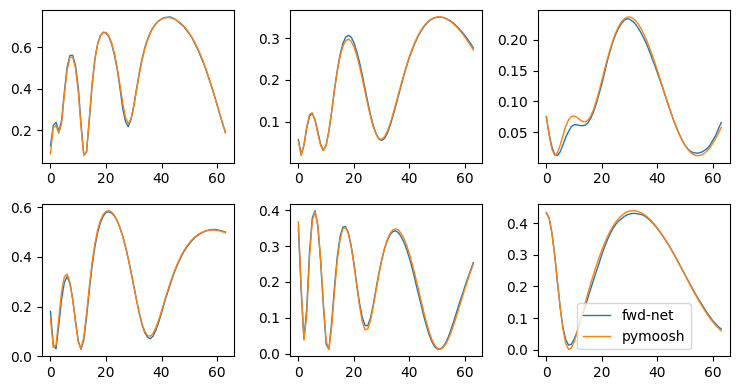

In [3]:
model_path = 'models/fwd_model_resnet.h5'

# load pretrained forward model
fwd_model = keras.models.load_model(model_path)
fwd_model.trainable = False

# quick test if model works
y_predict = fwd_model.predict(x_test, verbose=0)
helper.plot_benchmark_R_model(y_predict, y_test, N_plot=(2,3))

### Inverse resnet model

*Note*, instead of `MaxPooling`, we here use `strides=2` to reduce the output dimension of a convolution by a factor of 2. In the up-sampling case (see forward model), strides can also be used with transpose convolutions to increase the output dimension. However the latter often leads to artifacts in the upsampled outputs, therefore for a robust first try dedicated `UpSampling` layers are preferred. 

In the down-sampling case, strides usually don't induce artifacts and are computationally cheaper as well as are more flexible (they are trainable), in contrast to `MaxPooling`.

In [4]:
keras.backend.clear_session()
N_blocks = 4     # Nr of resblocks between upsamplings


# spectrum in
target_spec_input = keras.layers.Input(shape=y_train.shape[1:])
x = target_spec_input

for i in range(N_blocks):
    x = helper.residual_block(x, 32, kernel_size=3, strides=1)
# use strides=2 for downsampling. 64 --> 32
x = helper.residual_block(x, 32, kernel_size=3, strides=2)

for i in range(N_blocks):
    x = helper.residual_block(x, 64, kernel_size=3, strides=1)
x = helper.residual_block(x, 64, kernel_size=3, strides=2)   # 32 --> 16

for i in range(N_blocks):
    x = helper.residual_block(x, 128, kernel_size=3, strides=1)
x = helper.residual_block(x, 128, kernel_size=3, strides=2)   # 16 --> 8

x = keras.layers.ZeroPadding1D((1, 1))(x)             # 8 --> 1 + 8 + 1 --> 10
for i in range(N_blocks):
    x = helper.residual_block(x, 256, kernel_size=3, strides=1)
x = helper.residual_block(x, 256, kernel_size=3, strides=2)  # 10 --> 5

# design out
design_output = keras.layers.Conv1D(
    filters=2, kernel_size=1, padding='same')(x)

inverse_model = keras.models.Model(
    inputs=target_spec_input, outputs=design_output, name='resnet_inverse_model')
inverse_model.summary()

Model: "resnet_inverse_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 1)]      0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 64, 32)       64          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 32)       0           ['conv1d_1[0][0]']               
                                                                                                  
 conv1d_2 (Conv1D)              (None, 64, 32)       3104        ['leaky_re_lu[0][0]']            
                                                                               

### Define the full tandem model

Training the inverse model directly on the data does not work because of the problem's ill posed character. We therefore train it through the forward network.
To this end we feed the inverse model (generator) output into the pre-trained forward model and create a new "tandem" model. 
Printing the model's summary we see that only about half of the parameters are trainable, confirming that we fixed the forward model's weights.

In [5]:
# inverse_model_model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# get the inputs. alternatively we can re-use the layer as defined in the model above
tandem_input = inverse_model.inputs
inverse_output = inverse_model(tandem_input)
tandem_output = fwd_model(inverse_output)

tandem = keras.models.Model(inputs=tandem_input, outputs=tandem_output)

tandem.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 1)]           0         
                                                                 
 resnet_inverse_model (Funct  (None, 5, 2)             2270754   
 ional)                                                          
                                                                 
 resnet_model (Functional)   (None, 64, 1)             1818337   
                                                                 
Total params: 4,089,091
Trainable params: 2,270,754
Non-trainable params: 1,818,337
_________________________________________________________________


## Tandem training

Now we compile the model with an optimizer (`AdamW`) and mean square error loss, we add callbacks and then run the training.

### Note on training data

The full tandem model takes as input the design target spectrum and returns the predicted spectrum of the suggested geometry. Therefore we do not use the geometries for training anymore, but we use the spectra for both, in- and output. 

In [6]:
# compile with optimizer and cost function
tandem.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.001),
               loss='mse')

## ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=1/3, patience=5, verbose=1)

# callback for checkpoint saving
checkpoint_save = ModelCheckpoint(filepath='checkpoints/tandem/',
                                  monitor='val_loss', save_weights_only=True, save_best_only=True)

history = tandem.fit(x=y_train, y=y_train,
                     validation_split=.2,
                     batch_size=32, epochs=50,
                     callbacks = [reduce_lr, checkpoint_save])


Epoch 1/50


2023-06-21 15:52:54.115574: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f513ff11f90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-21 15:52:54.115607: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-06-21 15:52:54.118864: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-21 15:52:54.225527: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1188/1188 [==============================] - 83s 53ms/step - loss: 0.0124 - val_loss: 0.0037 - lr: 0.0010
Epoch 2/50
1188/1188 [==============================] - 60s 51ms/step - loss: 0.0032 - val_loss: 0.0032 - lr: 0.0010
Epoch 3/50
1188/1188 [==============================] - 60s 50ms/step - loss: 0.0025 - val_loss: 0.0025 - lr: 0.0010
Epoch 4/50
1188/1188 [==============================] - 59s 49ms/step - loss: 0.0022 - val_loss: 0.0032 - lr: 0.0010
Epoch 5/50
1188/1188 [==============================] - 60s 51ms/step - loss: 0.0022 - val_loss: 0.0018 - lr: 0.0010
Epoch 6/50
1188/1188 [==============================] - 59s 50ms/step - loss: 0.0022 - val_loss: 0.0025 - lr: 0.0010
Epoch 7/50
1188/1188 [==============================] - 59s 50ms/step - loss: 0.0020 - val_loss: 0.0022 - lr: 0.0010
Epoch 8/50
1188/1188 [==============================] - 59s 50ms/step - loss: 0.0021 - val_loss: 0.0038 - lr: 0.0010
Epoch 9/50
1188/1188 [==============================] - 60s 50ms/step - los

## save the models

In [12]:
tandem.save('models/inversenet_tandem_full.h5')
inverse_model.save('models/inversenet_tandem_generator.h5')

## plot loss convergence during training

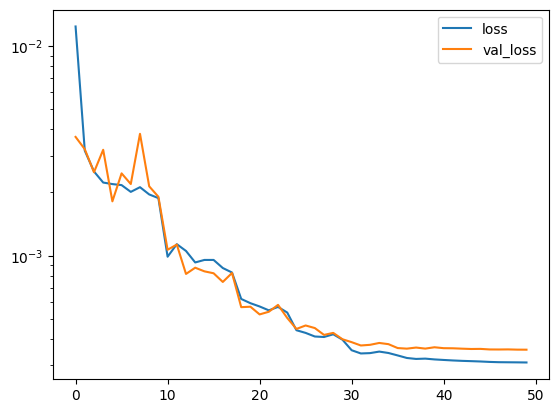

In [9]:
# plot the learning convergence
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.yscale('log')
plt.legend()
plt.show()

## test inverse designs suggested by the tandem model

We undertake following steps:

- predict inverse designs for the test-set spectra
- use the forward network to predict spectra of the inverse designs
- use pymoosh to calculate the spectra of the inverse designs
- plot samples and error statistics

For the other inverse design notebooks, the recalculation of the R-spectra via pymoosh as it is done here, is available in a `helper` function `helper.calc_R_for_network_designs`

pymoosh: calculating R for 2500 samples...


2500it [00:23, 105.07it/s]


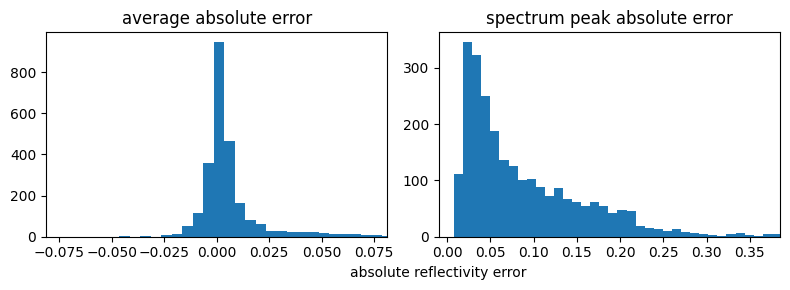

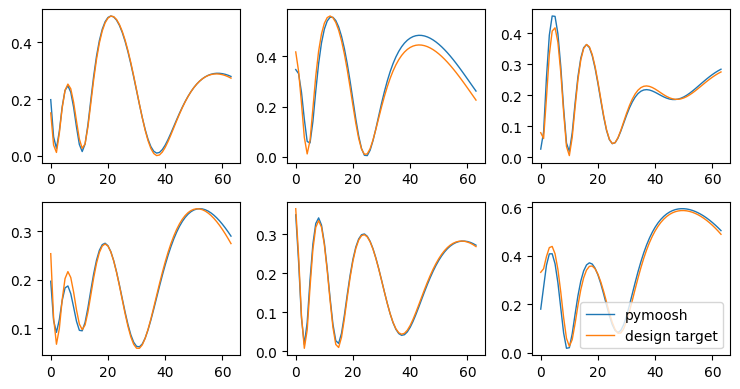

In [11]:
# predict designs and their R-spectra (via forward model)
designs_predict = inverse_model.predict(y_test, verbose=0)
y_predict = fwd_model.predict(designs_predict, verbose=0)

# scaler inverse transform: normalized datarange --> physical datarange
mat_physical = scaler_mat.inverse_transform(designs_predict[..., 0])
thick_physical = scaler_thick.inverse_transform(designs_predict[..., 1])

# pymoosh calculation of all designs
wavelengths = np.linspace(500, 1500, 64)
y_recalc = helper.batch_calc_R(thick_physical, mat_physical, wavelengths)

# plot statistics and samples
# helper.plot_benchmark_R_model(y_predict, y_test, labels=['fwd-net', 'design target'])
helper.plot_benchmark_R_model(y_recalc, y_test, labels=['pymoosh', 'design target'])